In [1]:
import pickle

# Load meta dict

with open('../../PNC/AllSubjectsMeta.bin', 'rb') as f:
    meta = pickle.load(f)
    
# Load rest subject ids and splits

with open('../../Work/Abstract/PaperBin/AllThreeSplit.bin', 'rb') as f:
    splits = pickle.load(f)
    subids = splits['allThreeYesWrat']
    groups = splits['groups']
    
print(len(subids))

593


In [2]:
import numpy as np

subidsNp = np.array(subids)

# Load timeseries

def loadSeries(prefix, para, idx):
    with open('{:}/{:}_fmri_power264/timeseries/{:}.bin'.format(prefix, para, idx), 'rb') as f:
        return pickle.load(f)

rest_ts = [loadSeries('../../PNC', 'rest', meta[subid]['rest']) for subid in subidsNp]
nback_ts = [loadSeries('../../PNC', 'nback', meta[subid]['nback']) for subid in subidsNp]
emoid_ts = [loadSeries('../../PNC', 'emoid', meta[subid]['emoid']) for subid in subidsNp]

print('Loading complete')

Loading complete


In [3]:
import numpy as np

def normalizeSubjects(subjects):
    for i in range(len(subjects)):
        subj = subjects[i]
        subj -= np.mean(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        subj /= np.std(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        if np.sum(np.isnan(subj)) > 0:
            print(i)
        if np.sum(np.isinf(subj)) > 0:
            print(i)

normalizeSubjects(rest_ts)
normalizeSubjects(nback_ts)
normalizeSubjects(emoid_ts)

print('Complete')

Complete


In [4]:
# Calculate pearson matrices

rest_p = np.stack([np.corrcoef(sub) for sub in rest_ts])
nback_p = np.stack([np.corrcoef(sub) for sub in nback_ts])
emoid_p = np.stack([np.corrcoef(sub) for sub in emoid_ts])

print(rest_p.shape)
print('Complete')

(593, 264, 264)
Complete


In [6]:
# Create feature vectors (right now just ages, maleness, and femaless)

males = 0
females = 0

X_all = []
for subid in subidsNp:
    subj = meta[subid]
    maleness = 1 if subj['meta']['Gender'] == 'M' else 0
    femaleness = 1 if maleness == 0 else 0
    feat = np.array([subj['meta']['AgeInMonths'], maleness, femaleness])
    X_all.append(feat)
    if maleness == 1:
        males += 1
    if femaleness == 1:
        females += 1
X_all = np.vstack(X_all)

print(f'{males} {females}')
print(X_all[10:20])
print('Complete')

271 322
[[223   1   0]
 [190   0   1]
 [197   0   1]
 [145   1   0]
 [148   0   1]
 [142   0   1]
 [123   1   0]
 [176   1   0]
 [129   0   1]
 [173   1   0]]
Complete


In [7]:
import torch

def convertTorch(p):
    t = torch.from_numpy(p).float()
    u = []
    for i in range(t.shape[0]):
        u.append(t[i][torch.triu_indices(264,264,offset=1).unbind()])
    return torch.stack(u).cuda()

def normalizeP(p):
    return p - torch.mean(p) # torch.mean(p, dim=1, keepdim=True)

rest_p_t = convertTorch(rest_p)
nback_p_t = convertTorch(nback_p)
emoid_p_t = convertTorch(emoid_p)

# rest_p_t = normalizeP(rest_p_t)
# nback_p_t = normalizeP(nback_p_t)
# emoid_p_t = normalizeP(emoid_p_t)

print(rest_p_t.shape)
print(nback_p_t.shape)
print(emoid_p_t.shape)
print('Complete')

torch.Size([593, 34716])
torch.Size([593, 34716])
torch.Size([593, 34716])
Complete


In [8]:
wratDict = dict()

with open('../../PNC/wrat.csv', 'r') as f:
    lines = f.readlines()[1:]
    for line in lines:
        line = line.strip().split(',')
        wratDict[line[0]] = {'raw': line[2], 'std': line[3]}

wrat = []

for key in subids:
    wrat.append(float(wratDict[str(key)]['std']))
    
wrat = np.array(wrat)
wrat_t = torch.from_numpy(wrat).float().cuda()

print('Complete')

Complete


In [57]:
import torch.nn as nn
import torch.nn.functional as F

def makePoly(ps, nPoly):
    pps = []
    for i in range(ps.shape[0]):
        p = ps[i].flatten()
        pp = nPoly*[None]
        for j in range(nPoly):
            pp[j] = p**(j+1)
        pps.append(torch.stack(pp))
    return torch.stack(pps)

def arith(n):
    return int(n*(n+1)/2)

def mask(e):
    return e - torch.diag(torch.diag(e.detach()))

class PgiDiff(nn.Module):
    def __init__(self, w, nPara, nTgts, dp=0.5, dp2=0.1):
        super(PgiDiff, self).__init__()
        self.nPara = nPara
        self.nTgts = nTgts
        self.masks = []
        if type(w) == int:
            w = (nTgts+1)*[w]
        for i in range(nTgts+1):
            self.masks.append(nn.Parameter(
                1e-4*torch.randn(nPara,arith(263),w[i]).float().cuda()
            ))
        self.dp = nn.Dropout(p=dp)
        self.dp2 = nn.Dropout(p=dp2)
    
    def getLatentsAndEdges(self, x, i, univ):
        if univ:
            y = torch.einsum('abc,bce->ae', x, self.masks[0])
            z = torch.einsum('abc,bce->ae', x, self.masks[i+1])
            y = F.softmax(y, dim=1)
            z = F.softmax(z, dim=1)
            e = y@z.T
            e = e + e.T
            return y, z, e
        else:
            y = torch.einsum('abc,bce->ae', x, self.masks[i+1])
            e = y@y.T
            return y, y, e
        
    def forward(self, x, y, testIdcs=None, univ=True):
        x = self.dp(x)
        res = []
#         sav = []
        for i in range(self.nTgts):
            j = int(i/2)
            _, _, e = self.getLatentsAndEdges(x[:,j:j+1,:], i, univ)
            if testIdcs is not None:
                e[:,testIdcs] = 0
            e = self.dp2(e)
            e = mask(e)
            e[e == 0] = float('-inf')
#             sav.append(e)
            e = 1.1*F.softmax(e, dim=1)
            e = e*y[i].unsqueeze(0)
            res.append(torch.sum(e, dim=1))
#         for i in range(2):
#             e = F.softmax(sav[i]+sav[i+2], dim=1)
#             e = e*y[i].unsqueeze(0)
#             res.append(torch.sum(e, dim=1))
        return res
        
print('Complete')

Complete


In [95]:
ceLoss = torch.nn.CrossEntropyLoss()
mseLoss = torch.nn.MSELoss()
nEpochs = 2000
pPeriod = 200
thresh = torch.Tensor((5,40,20)).float().cuda()

para = [nback_p_t, emoid_p_t]
    
rmse = []

def xform(data, stats=None, fwd=True):
    if stats is None:
        mu = torch.mean(data, dim=0, keepdim=True)
        sd = torch.std(data, dim=0, keepdim=True)
        return (mu, sd)
    elif fwd:
        return (data - stats[0])/stats[1]
    else:
        return data*stats[1] + stats[0]

for i in range(10):
    pgigcn = PgiDiff(2, len(para), 1, 0.5, 0.1)
    optim = torch.optim.Adam(pgigcn.masks, lr=1e-4, weight_decay=1e-4)

    trainIdcs = groups[i][0]
    testIdcs = groups[i][1]
    
    X = torch.stack(para, dim=1)
    X = X[trainIdcs]
    Y = torch.from_numpy(X_all[trainIdcs]).float().cuda()
    
    gen = Y[:,1:]
    wrt = wrat_t[trainIdcs]
    age = Y[:,0]
    
    # Normalize dataset
    statsGen = xform(gen)
    statsWrt = xform(wrt)
    statsAge = xform(age)
    
    # Transformed
    genT = xform(gen, statsGen)
    wrtT = xform(wrt, statsWrt)
    ageT = xform(age, statsAge)
    
#     y = torch.cat([ageT.unsqueeze(1), genT, wrtT.unsqueeze(1)], dim=1).T
    y = torch.cat([wrtT.unsqueeze(1), wrtT.unsqueeze(1)], dim=1).T
    
    for epoch in range(nEpochs):
        optim.zero_grad()
        res = pgigcn(X, y, univ=True)
#         avg = (res[0]+res[1])/2
        loss0 = mseLoss(xform(res[0], statsWrt, fwd=False), wrt)
#         loss1 = mseLoss(xform(res[1], statsWrt, fwd=False), wrt)
#         loss2 = mseLoss(xform(avg, statsWrt, fwd=False), wrt)
#         loss0 = ceLoss(torch.stack([res[0], res[1]], dim=1), gen)
#         loss1 = ceLoss(torch.stack([res[2], res[3]], dim=1), gen)
#         loss2 = ceLoss(torch.stack([res[4], res[5]], dim=1), gen)
#         lossR = 1e-5*torch.sum(torch.abs(torch.cat(pgigcn.masks[1:])))
#         loss = torch.stack([loss0, loss1, loss2])
        loss = torch.stack([loss0])
        torch.sum(loss).backward()
        optim.step()
        if (epoch % pPeriod == 0 or epoch == nEpochs-1):
            print(f'epoch {epoch} loss={(float(loss0), float(-1), float(-1))}')
        if torch.all(loss[0:3] < thresh):
            print('Early stopping')
            break
            
    print('Finished training')
    
    pgigcn.eval()
    
    X = torch.stack(para, dim=1)
    Y = torch.from_numpy(X_all).float().cuda()
        
    gen = Y[:,1:]
    wrt = wrat_t
    age = Y[:,0]
    
    # Transformed
    genT = xform(gen, statsGen)
    wrtT = xform(wrt, statsWrt)
    ageT = xform(age, statsAge)
    
#     y = torch.cat([ageT.unsqueeze(1), genT, wrtT.unsqueeze(1)], dim=1).T
    y = torch.cat([wrtT.unsqueeze(1), wrtT.unsqueeze(1)], dim=1).T
    
    with torch.no_grad():
        res = pgigcn(X, y, testIdcs, univ=True)
#         avg = (res[0]+res[2])/2
        loss0 = mseLoss(xform(res[0][testIdcs].detach(), statsWrt, fwd=False), wrt[testIdcs]).cpu().numpy()**0.5
#         loss1 = mseLoss(xform(res[1][testIdcs].detach(), statsWrt, fwd=False), wrt[testIdcs]).cpu().numpy()**0.5
#         loss2 = mseLoss(xform(avg[testIdcs].detach(), statsWrt, fwd=False), wrt[testIdcs]).cpu().numpy()**0.5
#         loss0 = torch.sum(torch.argmax(torch.stack([res[0], res[1]], dim=1).detach(), dim=1)[testIdcs] 
#                          == torch.argmax(gen[testIdcs], dim=1))/testIdcs.shape[0]
#         loss1 = torch.sum(torch.argmax(torch.stack([res[2], res[3]], dim=1).detach(), dim=1)[testIdcs] 
#                          == torch.argmax(gen[testIdcs], dim=1))/testIdcs.shape[0]
#         loss2 = torch.sum(torch.argmax(torch.stack([res[4], res[5]], dim=1).detach(), dim=1)[testIdcs] 
#                          == torch.argmax(gen[testIdcs], dim=1))/testIdcs.shape[0]

        rmse.append((float(loss0), float(-1), float(-1)))
        
    print(i, end=' ')
    print(rmse[-1])

epoch 0 loss=(259.3271484375, -1.0, -1.0)
epoch 200 loss=(19.836097717285156, -1.0, -1.0)
epoch 400 loss=(18.320968627929688, -1.0, -1.0)
epoch 600 loss=(14.340436935424805, -1.0, -1.0)
epoch 800 loss=(14.174041748046875, -1.0, -1.0)
epoch 1000 loss=(9.911443710327148, -1.0, -1.0)
epoch 1200 loss=(8.90350341796875, -1.0, -1.0)
epoch 1400 loss=(8.263893127441406, -1.0, -1.0)
epoch 1600 loss=(7.427967071533203, -1.0, -1.0)
epoch 1800 loss=(8.978059768676758, -1.0, -1.0)
epoch 1999 loss=(5.664045333862305, -1.0, -1.0)
Finished training
0 (14.262711524963379, -1.0, -1.0)
epoch 0 loss=(253.43508911132812, -1.0, -1.0)
epoch 200 loss=(43.90437316894531, -1.0, -1.0)
epoch 400 loss=(17.595861434936523, -1.0, -1.0)
epoch 600 loss=(12.90090560913086, -1.0, -1.0)
epoch 800 loss=(16.62000846862793, -1.0, -1.0)
epoch 1000 loss=(15.227018356323242, -1.0, -1.0)
epoch 1200 loss=(11.641947746276855, -1.0, -1.0)
epoch 1400 loss=(9.559715270996094, -1.0, -1.0)
epoch 1600 loss=(10.440467834472656, -1.0, -1

In [94]:
for a,b,c in rmse:
    print(a)

print()
print(np.mean(np.array([a for a,b,c in rmse])))
print(np.mean(np.array([b for a,b,c in rmse])))
print(np.mean(np.array([c for a,b,c in rmse])))

14.167952537536621
15.906243324279785
15.610169410705566
14.810810089111328
13.095734596252441
13.633976936340332
15.667797088623047
13.349231719970703
14.842735290527344
11.175155639648438

14.225980663299561
-1.0
-1.0


In [32]:
from torch_geometric.nn.dense import DenseGCNConv
import time

class GCN(nn.Module):
    def __init__(self, w, dp=0.5):
        super(GCN, self).__init__()
        self.gcn0 = DenseGCNConv(arith(263),w).float().cuda()
        self.gcn1 = DenseGCNConv(w,1).float().cuda()
        self.dp = nn.Dropout(p=dp)
        
    def forward(self, x):
        e = torch.ones(x.shape[0], x.shape[0]).float().cuda()/x.shape[0]
        x = self.dp(x)
        x = F.relu(self.gcn0(x,e)).squeeze()
        x = self.gcn1(x,e).squeeze()
        return x
    
class MLP(nn.Module):
    def __init__(self, w, dp=0.5):
        super(MLP, self).__init__()
        self.mlp0 = nn.Linear(arith(263),w).float().cuda()
        self.mlp1 = nn.Linear(w,2).float().cuda()
        self.dp = nn.Dropout(p=dp)
        
    def forward(self, x):
        x = self.dp(x)
        x = F.relu(self.mlp0(x)).squeeze()
        x = self.mlp1(x).squeeze()
        return x
    
ceLoss = torch.nn.CrossEntropyLoss()
mseLoss = torch.nn.MSELoss()
nEpochs = 10000
pPeriod = 200
thresh = torch.Tensor((50,50,50)).float().cuda()

para = [nback_p_t, emoid_p_t]
rmse = []

for i in range(10):
    gcn0 = GCN(40, 0.5)
    gcn1 = GCN(40, 0.5)
    optim = torch.optim.Adam(list(gcn0.parameters())+list(gcn1.parameters()), lr=1e-4, weight_decay=1e-4)

    trainIdcs = groups[i][0][0:30]
    testIdcs = groups[i][1] #np.concatenate([groups[i][1], groups[i][0][350:]])
    
    X = torch.stack(para, dim=1)
    X = X[trainIdcs]
    Y = torch.from_numpy(X_all[trainIdcs]).float().cuda()
    
    gen = Y[:,1:]
    wrt = wrat_t[trainIdcs]
    age = Y[:,0]
    
    for epoch in range(nEpochs):
        optim.zero_grad()
        res0 = gcn0(X[:,0,:])
        res1 = gcn1(X[:,1,:])
        avg = (res0+res1)/2
        loss0 = mseLoss(res0, wrt)
        loss1 = mseLoss(res1, wrt)
        loss2 = mseLoss(avg, wrt)
#         loss0 = ceLoss(res0, gen)
#         loss1 = ceLoss(res1, gen)
#         loss2 = ceLoss(avg, gen)
#         loss0 = ceLoss(torch.stack([res[0], res[1]], dim=1), gen)
#         loss1 = 0*ceLoss(torch.stack([res[2], res[3]], dim=1), gen)
#         loss2 = 0*ceLoss(torch.stack([avg0, avg1], dim=1), gen)
#         lossR = 8e1*torch.mean(torch.abs(torch.cat(pgigcn.masks[1:2]))) + 2e1*torch.mean((pgigcn.masks[1]-pgigcn.masks[2])**2)**0.5#torch.mean(torch.abs(torch.cat(pgigcn.masks[3:4])))
        loss = torch.stack([loss0, loss1, loss2])
        torch.sum(loss).backward()
        optim.step()
        if (epoch % pPeriod == 0 or epoch == nEpochs-1):
            print(f'epoch {epoch} loss={(float(loss0), float(loss1), float(loss2))}')
        if torch.all(loss[0:3] < thresh):
            print('Early stopping')
            break
            
    print('Finished training')
    
    gcn0.eval()
    gcn1.eval()
    
    X = torch.stack(para, dim=1)
    Y = torch.from_numpy(X_all).float().cuda()
        
    gen = Y[:,1:]
    wrt = wrat_t
    age = Y[:,0]
    
    with torch.no_grad():
        res0 = gcn0(X[:,0,:])
        res1 = gcn1(X[:,1,:])
        avg = (res0+res1)/2
        loss0 = mseLoss(res0[testIdcs], wrt[testIdcs]).cpu().numpy()**0.5
        loss1 = mseLoss(res1[testIdcs], wrt[testIdcs]).cpu().numpy()**0.5
        loss2 = mseLoss(avg[testIdcs], wrt[testIdcs]).cpu().numpy()**0.5
#         loss0 = torch.sum(torch.argmax(res0.detach(), dim=1)[testIdcs] 
#                          == torch.argmax(gen[testIdcs], dim=1))/testIdcs.shape[0]
#         loss1 = torch.sum(torch.argmax(res1.detach(), dim=1)[testIdcs] 
#                          == torch.argmax(gen[testIdcs], dim=1))/testIdcs.shape[0]
#         loss2 = torch.sum(torch.argmax(avg.detach(), dim=1)[testIdcs] 
#                          == torch.argmax(gen[testIdcs], dim=1))/testIdcs.shape[0]

        rmse.append((float(loss0), float(loss1), float(loss2)))
        
    print(i, end=' ')
    print(rmse[-1])

epoch 0 loss=(10683.23828125, 10768.5419921875, 10725.8369140625)
epoch 200 loss=(259.38983154296875, 251.69424438476562, 248.82766723632812)
epoch 400 loss=(239.24078369140625, 217.100341796875, 222.34815979003906)
epoch 600 loss=(217.9005584716797, 182.43692016601562, 195.2244873046875)
epoch 800 loss=(193.870361328125, 144.78636169433594, 164.49574279785156)
epoch 1000 loss=(166.90798950195312, 114.90177917480469, 136.26535034179688)
epoch 1200 loss=(137.4228515625, 91.6574935913086, 109.79474639892578)
epoch 1400 loss=(116.64170837402344, 67.55522155761719, 86.4842300415039)
epoch 1600 loss=(96.3808364868164, 52.12168884277344, 68.66283416748047)
epoch 1800 loss=(73.18289947509766, 39.583580017089844, 51.27973175048828)
epoch 2000 loss=(55.51068115234375, 27.980226516723633, 36.679508209228516)
Early stopping
Finished training
0 (15.537575721740723, 15.74785041809082, 15.399425506591797)
epoch 0 loss=(10831.8193359375, 10847.21484375, 10839.5078125)
epoch 200 loss=(248.824203491210

KeyboardInterrupt: 

/home/anton/.conda/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


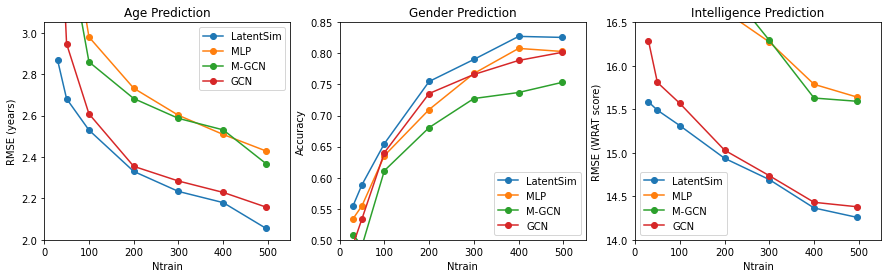

In [1]:
import matplotlib.pyplot as plt
import numpy as np

N = np.array([30,50,100,200,300,400,496])

mlp = np.array([(4.519032764,0.5338709533,21.1769804,0.435483858),
                (3.635566076,0.5548386961,19.06944923,0.47580643),
                (2.97935851,0.635483849,17.60164289,0.5064515948),
                (2.731894398,0.7096774042,16.62912073,0.5725806326),
                (2.601076889,0.7677419186,16.27460728,0.5999999881),
                (2.508576743,0.8080644906,15.7877099,0.5951612592),
                (2.428544792,0.8032257795,15.64097691,0.6096774042)])
mcn = np.array([(4.467671013,0.5080645025,23.27250633,0),
                (3.457302443,0.490322572,18.6066246,0),
                (2.859093332,0.6112902999,18.3394063,0),
                (2.682142576,0.680645138,16.93111067,0),
                (2.586293125,0.7274193347,16.29418049,0),
                (2.530755568,0.7370967507,15.62986822,0),
                (2.367032687,0.7532257915,15.5927434,0)])
gcn = np.array([(3.898489634,0.4919354677,16.28875179,0.4467741817),
                (2.946520138,0.5338709533,15.80897875,0.4225806355),
                (2.60816172,0.640322572,15.56916971,0.5177419275),
                (2.354796839,0.735483849,15.03067617,0.5758064359),
                (2.283823347,0.766129005,14.73714867,0.5983870775),
                (2.228807735,0.7887096465,14.43098822,0.5887096703),
                (2.157710552,0.8016128838,14.37997332,0.6177419186)])
sim = np.array([(2.866807715,0.5548386991,15.5857604,0.4564516068),
                (2.681079054,0.5887096584,15.49007683,0.5145161122),
                (2.529722166,0.6548386872,15.31333075,0.5467741758),
                (2.330266428,0.7548386812,14.93733768,0.5774193347),
                (2.233492406,0.7903225541,14.69237928,0.5935483694),
                (2.179487594,0.8274193227,14.36593857,0.5967741728),
                (2.054666424,0.825806427,14.25810738,0.6177419186)])

fig, ax = plt.subplots(1,3,figsize=(15,4))

for i in range(3):
    ax[i].plot(N,sim[:,i],label='LatentSim',marker='o')
    ax[i].plot(N,mlp[:,i],label='MLP',marker='o')
    ax[i].plot(N,mcn[:,i],label='M-GCN',marker='o')
    ax[i].plot(N,gcn[:,i],label='GCN',marker='o')
    ax[i].legend()
    ax[i].set_xlabel('Ntrain')
    ax[i].set_xlim([0,550])
    
ax[0].set_title('Age Prediction')
ax[1].set_title('Gender Prediction')
ax[2].set_title('Intelligence Prediction')
# ax[3].set_title('Age Group Prediction')

ax[0].set_ylabel('RMSE (years)')
ax[0].set_ylim([2,3.05])
ax[1].set_ylabel('Accuracy')
ax[1].set_ylim([.50,.85])
ax[2].set_ylabel('RMSE (WRAT score)')
ax[2].set_ylim([14,16.5])
# ax[3].set_ylabel('Accuracy')
# ax[3].set_ylim([.40,.72])
    
fig.show()
fig.savefig('../../Work/LatentSim/Prediction.png', format='png', bbox_inches='tight')

/home/anton/.conda/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


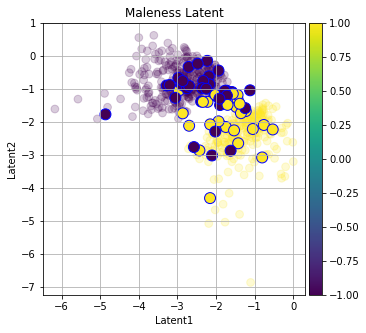

In [71]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable

y, _, e = pgigcn.getLatentsAndEdges(X[:,1:2,:], 2, False)
z, _, e = pgigcn.getLatentsAndEdges(X[:,0:1,:], 1, False)

e = e.detach().cpu().numpy()
y = y.detach().cpu().numpy()
z = z.detach().cpu().numpy()

fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.scatter(y[:,0],y[:,1],s=60,c=gen[:,0].detach().cpu().numpy(),alpha=0.2)
ax.scatter(y[testIdcs][:,0],y[testIdcs][:,1],s=120,c=gen[:,0][testIdcs].detach().cpu().numpy(),edgecolors='b')
ax.grid(True)
ax.set_xlabel('Latent1')
ax.set_ylabel('Latent2')
# ax.set_xlim((-1,2))
# ax.set_ylim((-1.5,1))
ax.set_title('Maleness Latent')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(cm.ScalarMappable(norm=Normalize(-1,1), cmap='viridis'), cax=cax, orientation='vertical')
fig.show()
# fig.savefig('../../Work/LatentSim/MaleLatent.png', format='png', bbox_inches='tight')

In [141]:
len(pgigcn.masks)

5

In [72]:
class PgiDiff(nn.Module):
    def __init__(self, w, nPara, nTgts, dp=0.5, dp2=0.1):
        super(PgiDiff, self).__init__()
        self.nPara = nPara
        self.nTgts = nTgts
        self.masks = []
        if type(w) == int:
            w = (nTgts+1)*[w]
        for i in range(nTgts+1):
            self.masks.append(nn.Parameter(
                1e-4*torch.rand(nPara,arith(263),w[i]).float().cuda()
            ))
        self.dp = nn.Dropout(p=dp)
        self.dp2 = nn.Dropout(p=dp2)
    
    def getLatentsAndEdges(self, x, i, univ):
        if univ:
            y = torch.einsum('abc,bce->ae', x, self.masks[0])
            z = torch.einsum('abc,bce->ae', x, self.masks[i+1])
            e = y@z.T
            e = e + e.T
            return y, z, e
        else:
            y = torch.einsum('abc,bce->ae', x, self.masks[i+1])
            e = y@y.T
            return y, y, e
        
    def forward(self, x, y, testIdcs=None, univ=True):
        x = self.dp(x)
        res = []
        for i in range(self.nTgts):
            _, _, e = self.getLatentsAndEdges(x, i, univ)
            if testIdcs is not None:
                e[:,testIdcs] = 0
            e = self.dp2(e)
            e = mask(e)
            e[e == 0] = float('-inf')
            e = 1.1*F.softmax(e, dim=1)
            e = e*y[i].unsqueeze(0)
            res.append(torch.sum(e, dim=1))
        return res
        
print('Complete')

ceLoss = torch.nn.CrossEntropyLoss()
mseLoss = torch.nn.MSELoss()
nEpochs = 2000
pPeriod = 200
thresh = torch.Tensor((40,0.15,10)).float().cuda()

para = [emoid_p_t]
rmse = []

def xform(data, stats=None, fwd=True):
    if stats is None:
        mu = torch.mean(data, dim=0, keepdim=True)
        sd = torch.std(data, dim=0, keepdim=True)
        return (mu, sd)
    elif fwd:
        return (data - stats[0])/stats[1]
    else:
        return data*stats[1] + stats[0]

for i in range(10):
    pgigcn = PgiDiff(2, len(para), 4, 0.5, 0.1)
    optim = torch.optim.Adam(pgigcn.masks, lr=1e-4, weight_decay=1e-4)

    trainIdcs = groups[i][0]
    testIdcs = groups[i][1]
    
    X = torch.stack(para, dim=1)
    X = X[trainIdcs]
    Y = torch.from_numpy(X_all[trainIdcs]).float().cuda()
    
    gen = Y[:,1:]
    wrt = wrat_t[trainIdcs]
    age = Y[:,0]
    
    # Normalize dataset
    statsGen = xform(gen)
    statsWrt = xform(wrt)
    statsAge = xform(age)
    
    # Transformed
    genT = xform(gen, statsGen)
    wrtT = xform(wrt, statsWrt)
    ageT = xform(age, statsAge)
    
    y = torch.cat([ageT.unsqueeze(1), genT, wrtT.unsqueeze(1)], dim=1).T
    
    for epoch in range(nEpochs):
        optim.zero_grad()
        res = pgigcn(X, y, univ=True)
        loss0 = mseLoss(xform(res[0], statsAge, fwd=False), age)
        loss1 = ceLoss(torch.stack([res[1], res[2]], dim=1), gen)
        loss2 = mseLoss(xform(res[3], statsWrt, fwd=False), wrt)
        loss = torch.stack([loss0, 10*loss1, 2*loss2])
        torch.sum(loss).backward()
        optim.step()
        if (epoch % pPeriod == 0 or epoch == nEpochs-1):
            print(f'epoch {epoch} loss={(float(loss0), float(loss1), float(loss2))}')
        if torch.all(loss[0:3] < thresh):
            print('Early stopping')
            break
            
    print('Finished training')
    
    pgigcn.eval()
    
    X = torch.stack(para, dim=1)
    Y = torch.from_numpy(X_all).float().cuda()
        
    gen = Y[:,1:]
    wrt = wrat_t
    age = Y[:,0]
    
    # Transformed
    genT = xform(gen, statsGen)
    wrtT = xform(wrt, statsWrt)
    ageT = xform(age, statsAge)
    
    y = torch.cat([ageT.unsqueeze(1), genT, wrtT.unsqueeze(1)], dim=1).T
    
    with torch.no_grad():
        res = pgigcn(X, y, testIdcs, univ=True)
        loss0 = mseLoss(xform(res[0][testIdcs].detach(), statsAge, fwd=False), age[testIdcs]).cpu().numpy()**0.5
        loss1 = torch.sum(torch.argmax(torch.stack([res[1], res[2]], dim=1).detach(), dim=1)[testIdcs] 
                         == torch.argmax(gen[testIdcs], dim=1))/testIdcs.shape[0]
        loss2 = mseLoss(xform(res[3][testIdcs].detach(), statsWrt, fwd=False), wrt[testIdcs]).cpu().numpy()**0.5

        rmse.append((float(loss0), float(loss1), float(loss2)))
        
    print(i, end=' ')
    print(rmse[-1])

Complete
epoch 0 loss=(1542.0074462890625, 0.6988629102706909, 257.8121032714844)
epoch 200 loss=(240.4414825439453, 0.4322591722011566, 138.03067016601562)
epoch 400 loss=(102.36082458496094, 0.2012401521205902, 48.62720489501953)
epoch 600 loss=(83.42269897460938, 0.17396681010723114, 32.21742248535156)
epoch 800 loss=(61.384071350097656, 0.15313288569450378, 28.44080924987793)
epoch 1000 loss=(68.15113830566406, 0.17357900738716125, 30.28565788269043)
epoch 1200 loss=(57.411460876464844, 0.1595049947500229, 29.582382202148438)
epoch 1400 loss=(81.70097351074219, 0.14200186729431152, 22.57207489013672)
epoch 1600 loss=(60.37431716918945, 0.19003190100193024, 21.782602310180664)
epoch 1800 loss=(53.22837829589844, 0.16076022386550903, 19.607301712036133)
epoch 1999 loss=(52.975521087646484, 0.1408306360244751, 18.629512786865234)
Finished training
0 (27.192249298095703, 0.7166666984558105, 14.567896842956543)
epoch 0 loss=(1514.57763671875, 0.7005168199539185, 250.89564514160156)
epoc

epoch 200 loss=(184.9251708984375, 0.6097191572189331, 132.1876220703125)
epoch 400 loss=(97.41970825195312, 0.3179534673690796, 46.11601638793945)
epoch 600 loss=(115.18974304199219, 0.30848243832588196, 36.81048583984375)
epoch 800 loss=(101.17852020263672, 0.25977274775505066, 39.13640594482422)
epoch 1000 loss=(66.0592269897461, 0.21939067542552948, 21.685810089111328)
epoch 1200 loss=(84.1578140258789, 0.21768811345100403, 23.88210678100586)
epoch 1400 loss=(56.15874099731445, 0.19312046468257904, 26.868316650390625)
epoch 1600 loss=(54.538909912109375, 0.21769188344478607, 22.926382064819336)
epoch 1800 loss=(88.57215881347656, 0.17664343118667603, 21.178592681884766)
epoch 1999 loss=(45.74724578857422, 0.1645643264055252, 17.780275344848633)
Finished training
9 (31.195274353027344, 0.7288135886192322, 11.613038063049316)


In [74]:
from sklearn.decomposition import PCA

u, _, _ = pgigcn.getLatentsAndEdges(X, 3, True)

u2 = u.detach().cpu().numpy()
# pca = PCA(n_components=2)
# pca.fit(u)
# print(pca.explained_variance_ratio_)
# print(pca.singular_values_)
# u2 = pca.transform(u)

/home/anton/.conda/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


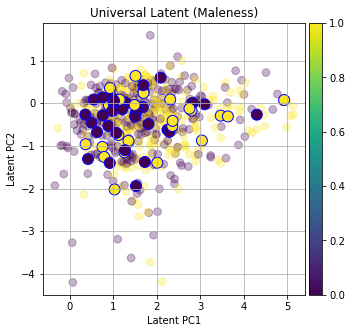

In [79]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.scatter(u2[:,0],u2[:,1],s=60,c=gen[:,0].detach().cpu().numpy(),alpha=0.3)
ax.scatter(u2[testIdcs][:,0],u2[testIdcs][:,1],s=120,c=gen[:,0][testIdcs].detach().cpu().numpy(),edgecolors='b')
ax.grid(True)
# ax.set_xlim(-2,2)
# ax.set_ylim(-2,2)
ax.set_xlabel('Latent PC1')
ax.set_ylabel('Latent PC2')
ax.set_title('Universal Latent (Maleness)')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(cm.ScalarMappable(norm=Normalize(0,1), cmap='viridis'), cax=cax, orientation='vertical')
fig.show()
# fig.savefig('../../Work/LatentSim/UniversalMaleLatent.png', format='png', bbox_inches='tight')